In [ ]:
import numpy as np

class HOONode:
    def __init__(self, depth, index):
        self.depth = depth
        self.index = index
        self.visits = 0
        self.mean_reward = 0.0
        self.upper_bound = float('inf')
        self.left_child = None
        self.right_child = None

class HOO:
    def __init__(self, nu1, rho, depth_limit):
        self.nu1 = nu1
        self.rho = rho
        self.depth_limit = depth_limit
        self.root = HOONode(0, 1)
        self.tree = {(0, 1): self.root}

    def select_node(self):
        path = []
        node = self.root
        while True:
            path.append(node)
            left_better = False
            right_better = False

            if node.left_child is not None and node.right_child is not None:
                if node.left_child.upper_bound > node.right_child.upper_bound:
                    left_better = True
                elif node.left_child.upper_bound < node.right_child.upper_bound:
                    right_better = True
                else:
                    left_better = np.random.choice([True, False])

            if node.left_child is None and node.depth < self.depth_limit:
                node.left_child = HOONode(node.depth + 1, 2 * node.index - 1)
                self.tree[(node.depth + 1, 2 * node.index - 1)] = node.left_child
                node = node.left_child
                path.append(node)
                break

            if node.right_child is None and node.depth < self.depth_limit:
                node.right_child = HOONode(node.depth + 1, 2 * node.index)
                self.tree[(node.depth + 1, 2 * node.index)] = node.right_child
                node = node.right_child
                path.append(node)
                break

            node = node.left_child if left_better else node.right_child

        return path, node

    def update_tree(self, path, reward):
        for node in reversed(path):
            node.visits += 1
            node.mean_reward = ((node.visits - 1) * node.mean_reward + reward) / node.visits
            exploration_term = np.sqrt(2 * np.log(len(path)) / node.visits)
            node.upper_bound = node.mean_reward + exploration_term + self.nu1 * self.rho ** node.depth

    def optimize(self, evaluate_func, num_iterations):
        rewards = []
        for _ in range(num_iterations):
            path, leaf_node = self.select_node()
            reward = evaluate_func(leaf_node.depth, leaf_node.index)
            rewards.append(reward)
            self.update_tree(path, reward)
        return rewards

def evaluate_func(depth, index):
    # Total parts at the current depth
    total_parts = 2 ** depth

    # Calculate the width of each part
    part_width = 1 / total_parts

    # Determine the mid-point of the interval for the given index
    # Note: index is 1-based and needs adjustment to 0-based for calculation
    mid_point = (index - 1) * part_width + part_width / 2

    # Evaluate the function at the mid-point
    reward = 0.9*(0.5*max(0,1-3*abs(0.5-mid_point))+ 0.5*max(0,1 - abs(0.5-mid_point))) # 0.9 to 0.65

    # Adding some noise to simulate real-world evaluation
    noise = np.random.normal(0, 0.1)  # small Gaussian noise # 1 to 0.55
    return reward + noise

# Initialize HOO and run optimization
hoo = HOO(nu1=1, rho=0.9, depth_limit=10)
rewards = hoo.optimize(evaluate_func, num_iterations=100)

In [ ]:
sum(rewards)

65.6792804071074

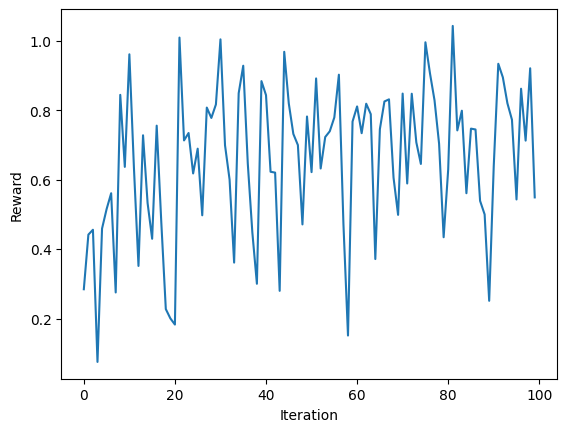

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(rewards)),rewards)
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()

In [ ]:
def optimize_parameters(nu1_range, rho_range, depth_limits, num_iterations):
    best_params = None
    max_reward = -np.inf

    # Grid search over nu1, rho, and depth_limits
    for nu1 in nu1_range:
        for rho in rho_range:
            for depth_limit in depth_limits:
                hoo = HOO(nu1=nu1, rho=rho, depth_limit=depth_limit)
                cumulative_reward = 0
                for _ in range(num_iterations):
                    path, leaf_node = hoo.select_node()
                    reward = evaluate_func(leaf_node.depth, leaf_node.index)
                    hoo.update_tree(path, reward)
                    cumulative_reward += reward

                print(f"nu1: {nu1}, rho: {rho}, depth_limit: {depth_limit}, Total Reward: {cumulative_reward}")

                if cumulative_reward > max_reward:
                    max_reward = cumulative_reward
                    best_params = (nu1, rho, depth_limit)

    return best_params, max_reward

# Define the parameter ranges
nu1_range = np.arange(0.1, 1.1, 0.1)  # nu1 from 0.1 to 1.0
rho_range = np.arange(0.7, 1.0, 0.05)  # rho from 0.7 to 0.95
depth_limits = [10, 11, 12, 13, 14, 15]  # Various depth limits

# Run the grid search
best_parameters, best_reward = optimize_parameters(nu1_range, rho_range, depth_limits, num_iterations=100)
print(f"Best parameters are nu1: {best_parameters[0]}, rho: {best_parameters[1]}, depth_limit: {best_parameters[2]} with a total reward of {best_reward}")